In [ ]:
# Swine Influenza WSI Classification

In [ ]:
#histopathology images classification
# our goal is to build a cnn model to classify WSI images
# the model will support veterinary pathologists diagnosis

In [5]:
# import libraries
import os
from glob import glob
import itertools
import fnmatch
import random
import matplotlib.pylab as plt
import seaborn as sns
import cv2
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, learning_curve, GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import keras
from keras import backend as K
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
sns.set()
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR, CyclicLR
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from matplotlib.pyplot import imread
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from glob import glob
from os import listdir
import time
import copy
from tqdm import tqdm_notebook as tqdm

In [2]:
# check the images folders
folders = os.listdir('/Users/DanDan/Downloads/AI-images/images')
folders

['0', '1']

In [6]:
# image path
imagePatches = glob('/Users/DanDan/Downloads/AI-images/images/**/*.bmp', recursive=True)
for filename in imagePatches[0:10]:
    print(filename)

/Users/DanDan/Downloads/AI-images/images/0/Lung 1.210.bmp
/Users/DanDan/Downloads/AI-images/images/0/Lung 1.204.bmp
/Users/DanDan/Downloads/AI-images/images/0/Lung 1.166.bmp
/Users/DanDan/Downloads/AI-images/images/0/Lung 1.172.bmp
/Users/DanDan/Downloads/AI-images/images/0/Lung 1.77.bmp
/Users/DanDan/Downloads/AI-images/images/0/Lung 1.63.bmp
/Users/DanDan/Downloads/AI-images/images/0/Lung 1.88.bmp
/Users/DanDan/Downloads/AI-images/images/0/Lung 1.89.bmp
/Users/DanDan/Downloads/AI-images/images/0/Lung 1.62.bmp
/Users/DanDan/Downloads/AI-images/images/0/Lung 1.76.bmp


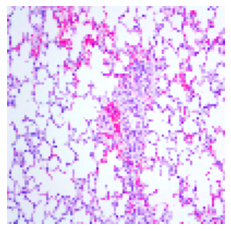

In [7]:
# plot single image
# resize the original images size 3585 X 2748  to 100 X 100 (limited by personal computer capacity)
image_name = '/Users/DanDan/Downloads/AI-images/images/0/Lung 1.210.bmp'
# image_name = "/Users/DanDan/Documents/GA/capstone/breast-cancer-info/archive/IDC_regular_ps50_idx5/9036/0/9036_idx5_x1051_y2401_class0.png" #Image to be used as query
def plotImage(image_location):
    image = cv2.imread(image_name)
    image = cv2.resize(image, (100,100))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)); plt.axis('off')
    return
# random view the images
plotImage(image_name)

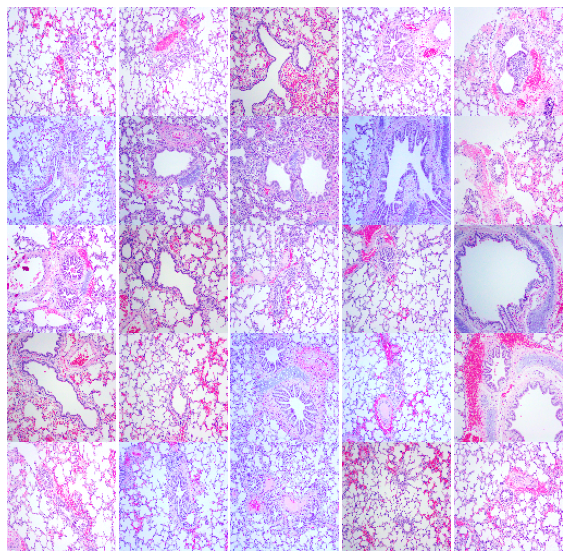

In [8]:
# Plot Multiple Images
bunchOfImages = imagePatches
i_ = 0
plt.rcParams['figure.figsize'] = (10, 10)
plt.subplots_adjust(wspace=0, hspace=0)
for l in bunchOfImages[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (100, 100)) 
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

In [9]:
# processing data
patternZero = '*Lung *'
patternOne = '*LungL*'
classZero = fnmatch.filter(imagePatches, patternZero)
classOne = fnmatch.filter(imagePatches, patternOne)
print("normal" ,classZero[0:5],'\n')
print("lesions",classOne[0:5])

normal ['/Users/DanDan/Downloads/AI-images/images/0/Lung 1.210.bmp', '/Users/DanDan/Downloads/AI-images/images/0/Lung 1.204.bmp', '/Users/DanDan/Downloads/AI-images/images/0/Lung 1.166.bmp', '/Users/DanDan/Downloads/AI-images/images/0/Lung 1.172.bmp', '/Users/DanDan/Downloads/AI-images/images/0/Lung 1.77.bmp'] 

lesions ['/Users/DanDan/Downloads/AI-images/images/1/LungL.1.41.bmp', '/Users/DanDan/Downloads/AI-images/images/1/LungL.1.40.bmp', '/Users/DanDan/Downloads/AI-images/images/1/LungL.1.8.bmp', '/Users/DanDan/Downloads/AI-images/images/1/LungL.1.42.bmp', '/Users/DanDan/Downloads/AI-images/images/1/LungL.1.43.bmp']


In [10]:
# build images format function
def proc_images(lowerIndex,upperIndex):
    """
    Returns two arrays: 
        x is an array of resized images
        y is an array of labels
    """ 
    x = []
    y = []
    WIDTH = 100
    HEIGHT = 100
    for img in imagePatches[lowerIndex:upperIndex]:
        full_size_image = cv2.imread(img)
        x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
        if img in classZero:
            y.append(0)
        elif img in classOne:
            y.append(1)
        else:
            return
    return x,y

In [11]:
X,Y = proc_images(0,90000)
df = pd.DataFrame()
df["images"]=X
df["labels"]=Y
X2=df["images"]
Y2=df["labels"]
X2=np.array(X2)
imgs0=[]
imgs1=[]
imgs0 = X2[Y2==0] # (0 = no IDC, 1 = IDC)
imgs1 = X2[Y2==1] 

In [12]:
def describeData(a,b):
    print('Total number of images: {}'.format(len(a)))
    print('Number of Normal Images: {}'.format(np.sum(b==0)))
    print('Number of Lesion Images: {}'.format(np.sum(b==1)))
    print('Percentage of positive images: {:.2f}%'.format(100*np.mean(b)))
    print('Image shape (Width, Height, Channels): {}'.format(a[0].shape))
describeData(X2,Y2)

Total number of images: 254
Number of Normal Images: 210
Number of Lesion Images: 44
Percentage of positive images: 17.32%
Image shape (Width, Height, Channels): (100, 100, 3)


In [13]:
# rename the labels
dict_characters = {0: 'normal', 1: 'lesion'}
print(df.head(10))
print("")
print(dict_characters)

                                              images  labels
0  [[[252, 234, 222], [244, 237, 230], [236, 149,...       0
1  [[[246, 239, 227], [244, 238, 223], [246, 240,...       0
2  [[[206, 127, 206], [192, 89, 88], [211, 166, 1...       0
3  [[[252, 207, 227], [254, 241, 233], [251, 242,...       0
4  [[[248, 239, 216], [245, 237, 230], [246, 235,...       0
5  [[[255, 194, 196], [255, 182, 189], [255, 174,...       0
6  [[[234, 215, 200], [234, 209, 191], [232, 210,...       0
7  [[[220, 160, 196], [227, 171, 189], [232, 169,...       0
8  [[[254, 213, 175], [235, 131, 147], [241, 145,...       0
9  [[[245, 224, 222], [240, 226, 221], [236, 231,...       0

{0: 'normal', 1: 'lesion'}


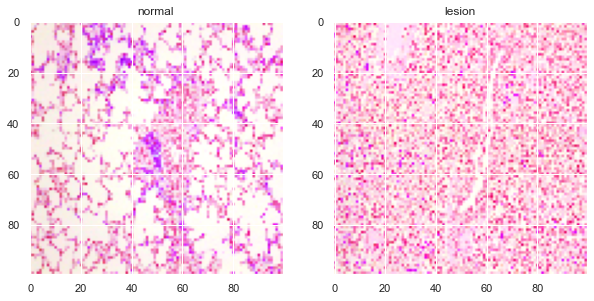

In [14]:
# plot one pair images
def plotOne(a,b):
    """
    Plot one numpy array
    """
    plt.subplot(1,2,1)
    plt.title('normal')
    plt.imshow(a[0])
    plt.subplot(1,2,2)
    plt.title('lesion')
    plt.imshow(b[0])
plotOne(imgs0, imgs1) 

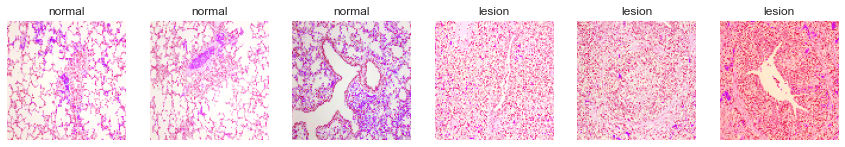

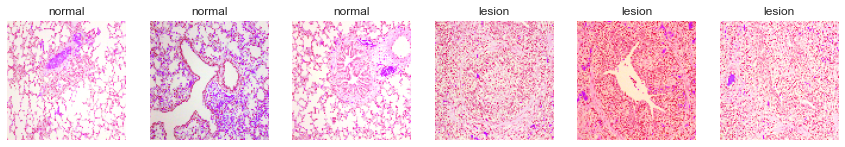

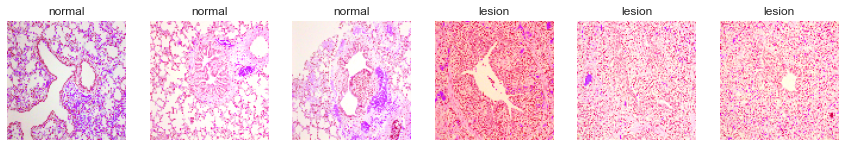

In [15]:
# plot pair images
def plotTwo(a,b): 
    """
    Plot a bunch of numpy arrays sorted by label
    """
    for row in range(3):
        plt.figure(figsize=(20, 10))
        for col in range(3):
            plt.subplot(1,8,col+1)
            plt.title('normal')
            plt.imshow(a[0+row+col])
            plt.axis('off')       
            plt.subplot(1,8,col+4)
            plt.title('lesion')
            plt.imshow(b[0+row+col])
            plt.axis('off')
plotTwo(imgs0, imgs1) 

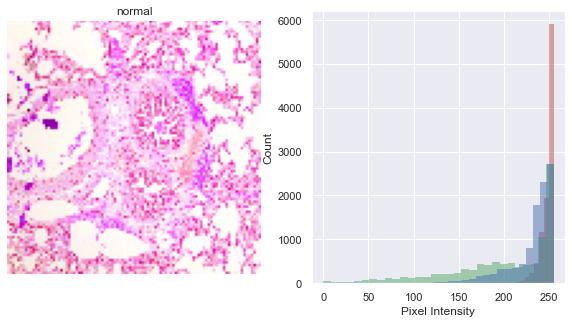

In [24]:
# the images and it's RGB density 
def plotHistogram(a):
    """
    Plot histogram of RGB Pixel Intensities
    """
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.axis('off')
    plt.title('lesion' if Y[1] else 'normal')
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);
plotHistogram(X2[10])

In [18]:
# split train and test dataset
X=np.array(X)
X=X/255.0

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
# Reduce Sample Size for DeBugging
X_train = X_train[0:300000] 
Y_train = Y_train[0:300000]
X_test = X_test[0:300000] 
Y_test = Y_test[0:300000]

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

Training Data Shape: (203, 100, 100, 3)
Testing Data Shape: (51, 100, 100, 3)


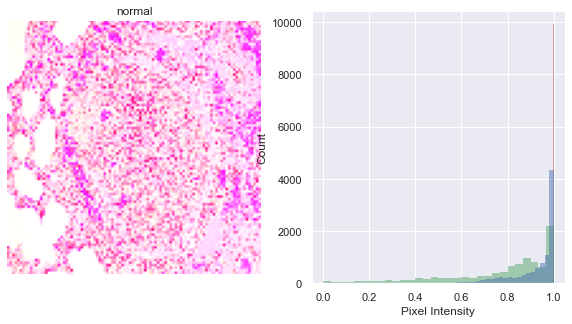

In [25]:
plotHistogram(X_train[10])

In [26]:
# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_trainHot = to_categorical(Y_train)
Y_testHot = to_categorical(Y_test)

{0: 'normal', 1: 'lesion'}


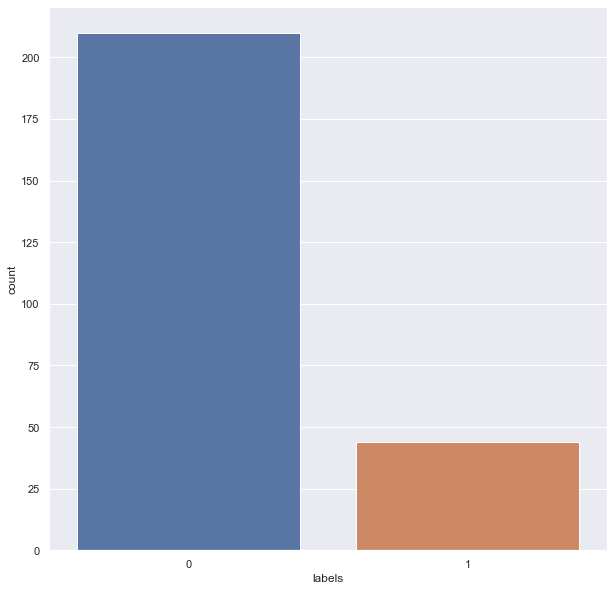

In [27]:
lab = df['labels']
dist = lab.value_counts()
sns.countplot(lab)
print(dict_characters)

{0: 'normal', 1: 'lesion'}


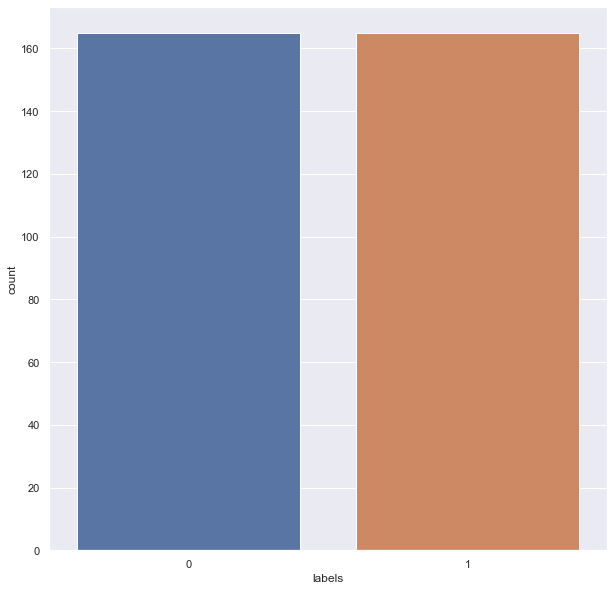

In [28]:
# Deal with imbalanced class sizes below
# Make Data 1D for compatability upsampling methods
X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
#ros = RandomOverSampler(ratio='auto')
ros = RandomOverSampler(sampling_strategy='auto')
X_trainRos, Y_trainRos = ros.fit_resample(X_trainFlat, Y_train)
X_testRos, Y_testRos = ros.fit_resample(X_testFlat, Y_test)

# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_trainRosHot = to_categorical(Y_trainRos, num_classes = 2)
Y_testRosHot = to_categorical(Y_testRos, num_classes = 2)

for i in range(len(X_trainRos)):
    height, width, channels = 100,100,3
    X_trainRosReshaped = X_trainRos.reshape(len(X_trainRos),height,width,channels)

for i in range(len(X_testRos)):
    height, width, channels = 100,100,3
    X_testRosReshaped = X_testRos.reshape(len(X_testRos),height,width,channels)
dfRos = pd.DataFrame()
dfRos["labels"]=Y_trainRos
labRos = dfRos['labels']
distRos = lab.value_counts()
sns.countplot(labRos)
print(dict_characters)

In [29]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced', np.unique(Y_train), Y_train)
print("Old Class Weights: ",class_weight)
from sklearn.utils import class_weight
class_weight2 = class_weight.compute_class_weight('balanced', np.unique(Y_trainRos), Y_trainRos)
print("New Class Weights: ",class_weight2)

Old Class Weights:  [0.61515152 2.67105263]
New Class Weights:  [1. 1.]


In [30]:
# Helper Functions Confusion Matrix
class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [31]:
# import deep learning library
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

In [48]:
# CNN models
model = Sequential()
# # 128-node hidden layer
# # 32 -node hidden layer
# model.add(Dense(128, activation = 'relu', kernel_regularizer= l2(0.001)))
model.add(Dense(64, activation= 'relu', kernel_regularizer= l2(0.001)))
model.add(Dense(32, activation= 'relu', kernel_regularizer= l2(0.001)))
model.add(Dense(16, activation= 'relu', kernel_regularizer= l2(0.001)))


model.add(Conv2D(filters = 6,       #number of filters to use
              kernel_size = (2, 2),   #dimensions of the filters
              activation = 'relu', 
                 padding = 'same',
              input_shape = (100, 100, 3)))  #shape of image
# dimensions of region of pooling
model.add(MaxPooling2D(pool_size = (2, 2)))   #filter dimensions

model.add(Conv2D(filters = 6,       #number of filters to use
              kernel_size = (2, 2),   #dimensions of the filters
              activation = 'relu', 
                 padding = 'same',
              input_shape = (100, 100, 3)))  #shape of image

model.add(MaxPooling2D(pool_size = (2, 2))) 
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation = 'relu', kernel_regularizer= l2(0.001)))
model.add(Dense(64, activation= 'relu', kernel_regularizer= l2(0.001)))
model.add(Dense(32, activation= 'relu', kernel_regularizer= l2(0.001)))
model.add(Dense(16, activation= 'relu', kernel_regularizer= l2(0.001)))
model.add(Dropout(0.25))
model.add(Dense(2, activation = 'sigmoid', kernel_regularizer= l2(0.001)))

# compile model
model.compile(loss = 'binary_crossentropy', optimizer ='adam', metrics = ['accuracy'])

# # Adding EarlyStopping
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 10, verbose = 1, mode = 'auto')

# Fit model on training data.
history = model.fit(X_trainRosReshaped, Y_trainRosHot,
                        validation_data=(X_testRosReshaped, Y_testRosHot),
                   batch_size = None, 
                   epochs = 50,
                    callbacks=[early_stop],
                   verbose = 2)
 # there is rule of thumb of batch_size, you use A good rule of thumb is to train on the entire set if the training dataset is fairly small (< 2,000 data), while otherwise choose a mini-batch size of 64, 128, 256, 512. It computes an exponentially weighted average of the gradients and uses that gradient to update the weights

Epoch 1/50
11/11 - 7s - loss: 1.0930 - accuracy: 0.5061 - val_loss: 1.0074 - val_accuracy: 0.7667
Epoch 2/50
11/11 - 5s - loss: 0.9731 - accuracy: 0.4879 - val_loss: 0.9295 - val_accuracy: 0.5000
Epoch 3/50
11/11 - 5s - loss: 0.9081 - accuracy: 0.5061 - val_loss: 0.8810 - val_accuracy: 0.6444
Epoch 4/50
11/11 - 5s - loss: 0.8661 - accuracy: 0.5788 - val_loss: 0.8483 - val_accuracy: 0.5000
Epoch 5/50
11/11 - 5s - loss: 0.8384 - accuracy: 0.4879 - val_loss: 0.8248 - val_accuracy: 0.6778
Epoch 6/50
11/11 - 5s - loss: 0.8172 - accuracy: 0.5424 - val_loss: 0.8063 - val_accuracy: 1.0000
Epoch 7/50
11/11 - 5s - loss: 0.8001 - accuracy: 0.6242 - val_loss: 0.7899 - val_accuracy: 0.9111
Epoch 8/50
11/11 - 5s - loss: 0.7851 - accuracy: 0.6848 - val_loss: 0.7752 - val_accuracy: 0.9778
Epoch 9/50
11/11 - 5s - loss: 0.7679 - accuracy: 0.7364 - val_loss: 0.7665 - val_accuracy: 0.5000
Epoch 10/50
11/11 - 6s - loss: 0.7693 - accuracy: 0.5303 - val_loss: 0.7363 - val_accuracy: 0.7333
Epoch 11/50
11/11 -

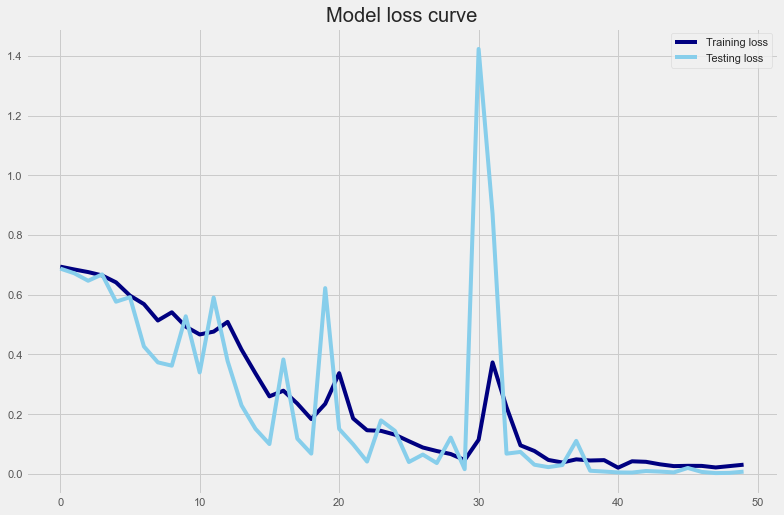

In [79]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']
plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.title('Model loss curve')
plt.legend();

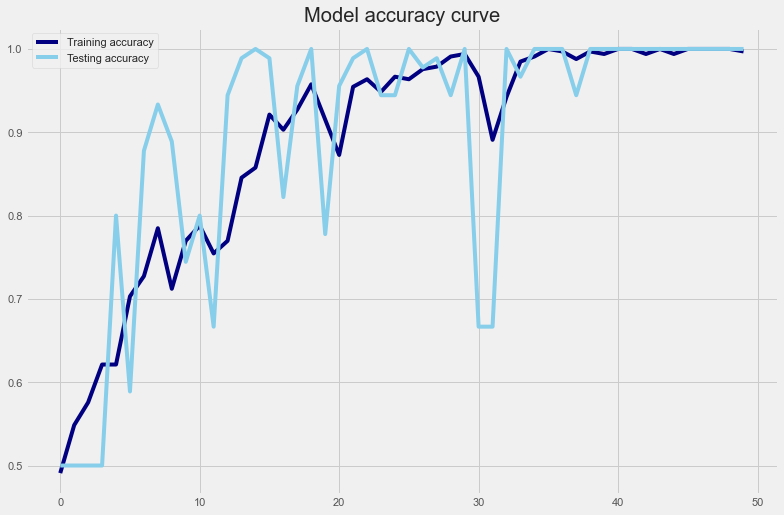

In [80]:
train_accuracy = history.history['accuracy']
test_accuracy = history.history['val_accuracy']
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 8))
plt.plot(train_accuracy, label='Training accuracy', color='navy')
plt.plot(test_accuracy, label='Testing accuracy', color='skyblue')
plt.title('Model accuracy curve')
plt.legend();

In [49]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_90 (Dense)             (None, 100, 100, 64)      256       
_________________________________________________________________
dense_91 (Dense)             (None, 100, 100, 32)      2080      
_________________________________________________________________
dense_92 (Dense)             (None, 100, 100, 16)      528       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 100, 100, 6)       390       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 50, 50, 6)         0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 50, 50, 6)         150       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 25, 25, 6)       

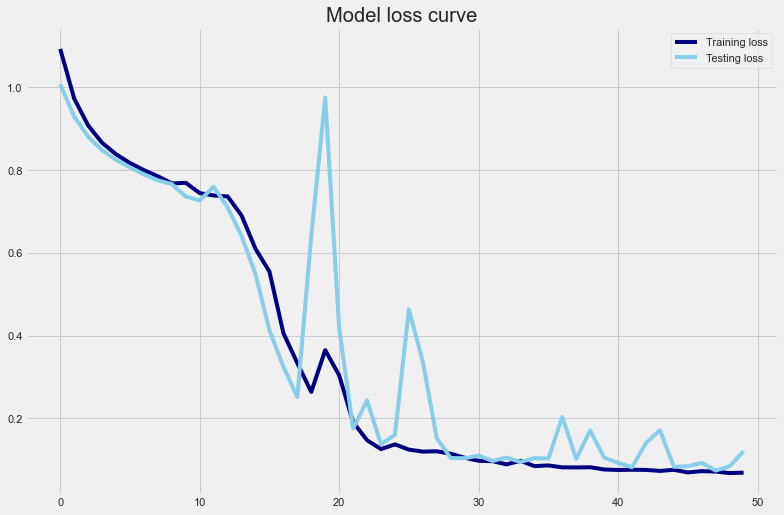

In [59]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']
plt.figure(figsize=(12, 8))
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.title('Model loss curve')
plt.legend();

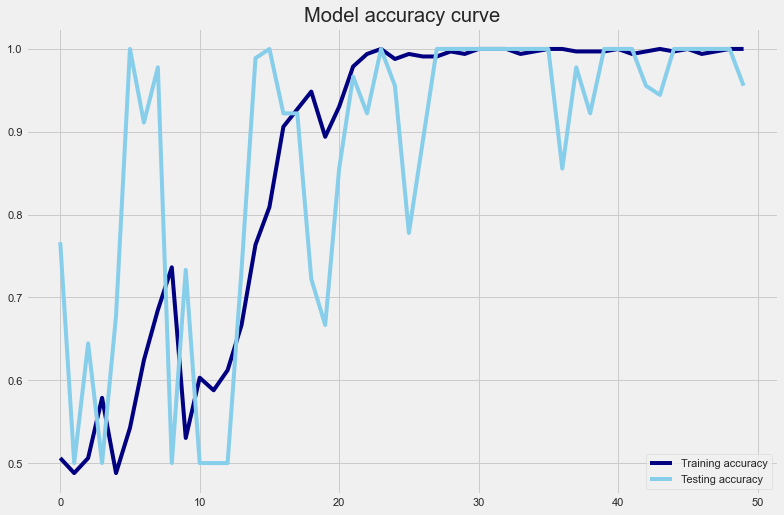

In [53]:
train_accuracy = history.history['accuracy']
test_accuracy = history.history['val_accuracy']
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 8))
plt.plot(train_accuracy, label='Training accuracy', color='navy')
plt.plot(test_accuracy, label='Testing accuracy', color='skyblue')
plt.title('Model accuracy curve')
plt.legend();

In [60]:
score = model.evaluate(X_testRosReshaped, Y_testRosHot, verbose=0)
print('\nKeras CNN #1C - accuracy:', score[1],'\n')


Keras CNN #1C - accuracy: 0.9555555582046509 



In [61]:
 y_pred = model.predict(X_testRosReshaped)
map_characters = {0: 'normal', 1: 'lesion'}
print('\n', sklearn.metrics.classification_report(np.where(Y_testRosHot > 0)[1], 
                                                  np.argmax(y_pred, axis=1), 
                                                  target_names=list(map_characters.values())), 
      sep='')    


              precision    recall  f1-score   support

      normal       1.00      0.91      0.95        45
      lesion       0.92      1.00      0.96        45

    accuracy                           0.96        90
   macro avg       0.96      0.96      0.96        90
weighted avg       0.96      0.96      0.96        90



In [62]:
Y_pred_classes = np.argmax(y_pred,axis=1) 
Y_true = np.argmax(Y_testRosHot,axis=1) 

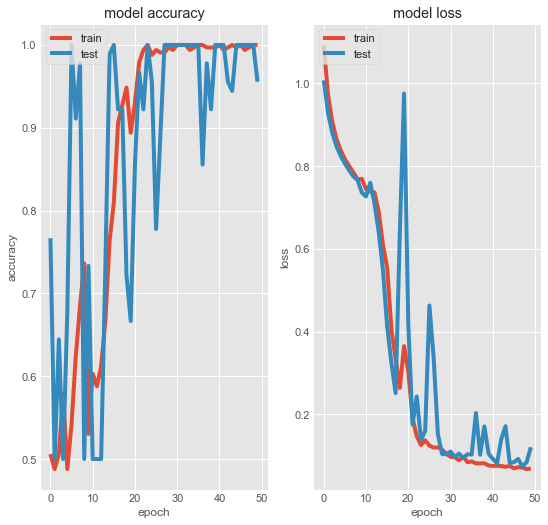

In [67]:
plot_learning_curve(history)
plt.style.use('fivethirtyeight')
plt.show()

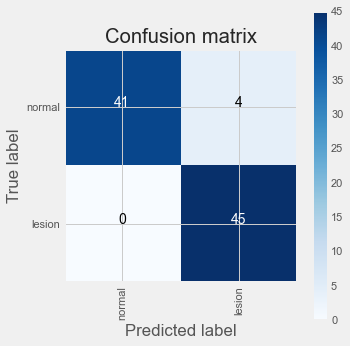

In [68]:
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
plt.show()